## Initial imports

In [1]:
import scm.plams as plams
from scm.params import ResultsImporter
from scm.plams import Settings, AMSJob, log, Molecule, packmol_on_slab
from pathlib import Path
import matplotlib.pyplot as plt

# common_ru_h.py must exist in the current working directory
from common_ru_h import (
    rotation,
    dft_settings,
    QEKPointsConfig,
    m3gnet_up_settings,
    replay_settings,
    slice_slab,
    check_installation,
)

# register dependencies for AMSjobs, to support submitting this notebook directly to a cluster in AMS2025+ 
# dependency: {}  common_ru_h.py
# dependency: {}  reference_data_2

## Initialize PLAMS working directory

In [2]:
old_ref_dir = "reference_data_2"
check_installation(old_ref_dir)
new_ref_dir = "reference_data_3"
ri = ResultsImporter.from_yaml(old_ref_dir)
plams.init()

Current AMS version: 2024.102
05-31 14:23:05 m3gnet is installed: M3GNet ML Backend v[0.2.4] - build:0 [06668e0a45ce742d8f66ff23484b8a1e]
05-31 14:23:06 qe is installed: Quantum ESPRESSO (AMSPIPE) v[7.1] - build:115 [777d72eb480fe4d632a003cc62e9c1cb]
PLAMS working folder: /home/hellstrom/SALRuH/fix2024/plams_workdir.003


## Construct the Ru(10-10)/H2(gas) interface

For details about the construction of the slab, see the previous notebook.

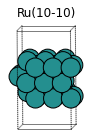

In [3]:
optimized_bulk = ri.job_collection["hcp_lattopt_Ru_dft"].molecule
slab_100 = slice_slab(
    optimized_bulk, miller=(1, 0, 0), thickness=7.0, cell_z=15, ref_atom=0
)
slab_100 = slab_100.supercell(3, 2, 1)
for at in slab_100:
    at.properties = Settings()  # remove details about supercell generation
plams.plot_molecule(slab_100, rotation=rotation)
plt.title("Ru(10-10)");

Now use the ``packmol_slab`` function to add hydrogen molecules:

In [4]:
from scm.plams import packmol_on_slab

h2_mol = plams.from_smiles("[HH]")
density = 0.3  # approximate density of the gas phase in g/cm^3
slab_100_H2_gas_raw = packmol_on_slab(slab_100, h2_mol, density=density)
slab_100_H2_gas = plams.preoptimize(
    slab_100_H2_gas_raw, settings=m3gnet_up_settings(), maxiterations=100
)

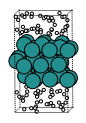

In [5]:
plams.plot_molecule(slab_100_H2_gas, rotation=rotation, radii=0.8)

Now let's run some MD:

In [6]:
mdjob = plams.AMSNVTJob(
    settings=m3gnet_up_settings(),
    name="md_ru10-10_h2_m3gnet",
    temperature=501,
    nsteps=10000,
    molecule=slab_100_H2_gas,
    samplingfreq=100,
)
mdjob.run();

[31.05|14:23:35] JOB md_ru10-10_h2_m3gnet STARTED
[31.05|14:23:35] JOB md_ru10-10_h2_m3gnet RUNNING
[31.05|15:08:27] JOB md_ru10-10_h2_m3gnet FINISHED
[31.05|15:08:28] JOB md_ru10-10_h2_m3gnet SUCCESSFUL


In [7]:
from scm.params import ResultsImporter

ri = ResultsImporter.from_yaml(old_ref_dir)

In [8]:
settings = dft_settings(QEKPointsConfig(3, 3, 1))
settings += replay_settings(mdjob.results.rkfpath(), frames=[10, 30, 50, 70, 90])

dft_replay_job = plams.AMSJob(
    settings=settings,
    name="snapshots_from_md_ru10-10_h2_dft",
)
dft_replay_job.run(watch=True)

[31.05|15:08:28] JOB snapshots_from_md_ru10-10_h2_dft STARTED
[31.05|15:08:28] JOB snapshots_from_md_ru10-10_h2_dft RUNNING
[31.05|15:08:29] snapshots_from_md_ru10-10_h2_dft: AMS 2024.102  RunTime: May31-2024 15:08:29  ShM Nodes: 1  Procs: 1
[31.05|15:08:29] snapshots_from_md_ru10-10_h2_dft: Starting trajectory replay ...
[31.05|15:08:29] snapshots_from_md_ru10-10_h2_dft: Replaying frame #1/5 (#10 in original trajectory)
[31.05|15:08:29] snapshots_from_md_ru10-10_h2_dft:     NOTE: a single QE.Label is assigned to atoms of different species.
[31.05|15:08:30] snapshots_from_md_ru10-10_h2_dft:     AMS Pseudopotentials Finder
[31.05|15:08:30] snapshots_from_md_ru10-10_h2_dft:     ---------------------------
[31.05|15:08:30] snapshots_from_md_ru10-10_h2_dft:       PP library: /home/hellstrom/.scm/packages/AMS2024.1.packages/qe-_5399rm6/content/upf_files
[31.05|15:08:30] snapshots_from_md_ru10-10_h2_dft:       * Ru
[31.05|15:08:30] snapshots_from_md_ru10-10_h2_dft:         Path: GGA/PBE/SR/S

In [9]:
ri.add_trajectory_singlepoints(dft_replay_job, properties=["energy", "forces"])
ri.store(new_ref_dir)

['reference_data_3/job_collection.yaml',
 'reference_data_3/results_importer_settings.yaml',
 'reference_data_3/training_set.yaml']